In [1]:
from __future__ import print_function
import datetime
import time
from functools import reduce
from collections import defaultdict
import os
import tqdm
import gzip
import pickle

import pyarrow.parquet as parquet
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numba

from fastset import FastSet

In [2]:
#   DBS BLOCKS table schema:
#     BLOCK_ID NOT NULL NUMBER(38)
#     BLOCK_NAME NOT NULL VARCHAR2(500)
#     DATASET_ID NOT NULL NUMBER(38)
#     OPEN_FOR_WRITING NOT NULL NUMBER(38)
#     ORIGIN_SITE_NAME NOT NULL VARCHAR2(100)
#     BLOCK_SIZE NUMBER(38)
#     FILE_COUNT NUMBER(38)
#     CREATION_DATE NUMBER(38)
#     CREATE_BY VARCHAR2(500)
#     LAST_MODIFICATION_DATE NUMBER(38)
#     LAST_MODIFIED_BY VARCHAR2(500)
if not os.path.exists('data/block_size.npy'):
    # numpy readcsv couldn't handle the size :(
    blocksize = pd.read_csv("data/dbs_blocks.csv", dtype='i8', usecols=(0,5), names=['block_id', 'block_size'])
    np.save('data/block_size.npy', blocksize.values)
    blocksize = blocksize.values
else:
    blocksize = np.load('data/block_size.npy')

# We'll be accessing randomly, make a fast lookup
bsort = np.argsort(blocksize[:,0])
bsize_index = FastSet(blocksize[bsort, 0])
bsize_values = blocksize[bsort, 1]
bsize_values = np.append(bsize_values, 0)
def getsize(s):
    return bsize_values[np.searchsorted(bsize_index._set, s._set)].sum()

In [3]:
blockmap_filename = 'data/blockmap.pkl'
if not os.path.exists(blockmap_filename):
    blockmap_in = pd.read_csv("data/dbs_blocks.csv", dtype='i8', usecols=(0,2), names=['block_id', 'dataset_id'])
    blockmap = defaultdict(FastSet)
    for bid, dsid in blockmap_in.values:
        blockmap[dsid] += FastSet([bid])

    del blockmap_in
    with gzip.open(blockmap_filename, 'wb') as fout:
        pickle.dump(blockmap, fout)
else:
    with gzip.open(blockmap_filename) as fin:
        blockmap = pickle.load(fin)

In [4]:
ws_cmssw = parquet.read_table('data/working_set_cmssw').to_pandas()
ws_cmssw['working_set_blocks'] = ws_cmssw.apply(lambda x: FastSet(x.working_set_blocks), 'columns')

In [5]:
ws_fwjr = parquet.read_table('data/working_set_fwjr').to_pandas()
ws_fwjr['working_set_blocks'] = ws_fwjr.apply(lambda x: FastSet(x.working_set_blocks), 'columns')

In [6]:
#ws_classads = parquet.read_table('data/working_set_classads').to_pandas()
#ws_classads['working_set_blocks'] = ws_classads.apply(
#    lambda x: sum((blockmap[ds] for ds in x.working_set), FastSet()), 'columns')

In [7]:
#ws_xrootd = parquet.read_table('data/working_set_xrootd').to_pandas()
#ws_xrootd['working_set_blocks'] = ws_xrootd.apply(lambda x: FastSet(x.working_set_blocks), 'columns')

In [8]:
# join the data tier definitions
titles = ['id', 'data_tier', 'day', 'user']
datatiers = pd.read_csv('data/dbs_datatiers.csv', names=titles.set_index('id')

def add_datatiers(ws):
    ws['data_tier'] = datatiers.loc[ws.d_data_tier_id].data_tier.values
    
#add_datatiers(ws_classads)
add_datatiers(ws_cmssw)
#add_datatiers(ws_xrootd)
add_datatiers(ws_fwjr)

In [9]:
def filt(ws):
#    ws = ws_cmssw.loc[ws_cmssw['is_crab'] == True]
    return ws[ws['data_tier'].str.match('(|MINI|NANO)AOD')]

ws_cmssw_filt = filt(ws_cmssw)
#ws_classads_filt = filt(ws_classads)
#ws_xrootd_filt = filt(ws_xrootd)
ws_fwjr_filt = filt(ws_fwjr)

In [10]:
def dataByLoc(ws):
    data = ws.groupby('site_name').working_set_blocks.agg(lambda series: reduce(FastSet.union, series, FastSet())).map(getsize)
    return(data)

In [11]:
cmssw_set = dataByLoc(ws_cmssw)
fwjr_set = dataByLoc(ws_fwjr)
#classads_sites, classads_size = dataByLoc(ws_classads_filt)
#xrootd_sites, xrootd_size = dataByLoc(ws_xrootd_filt)

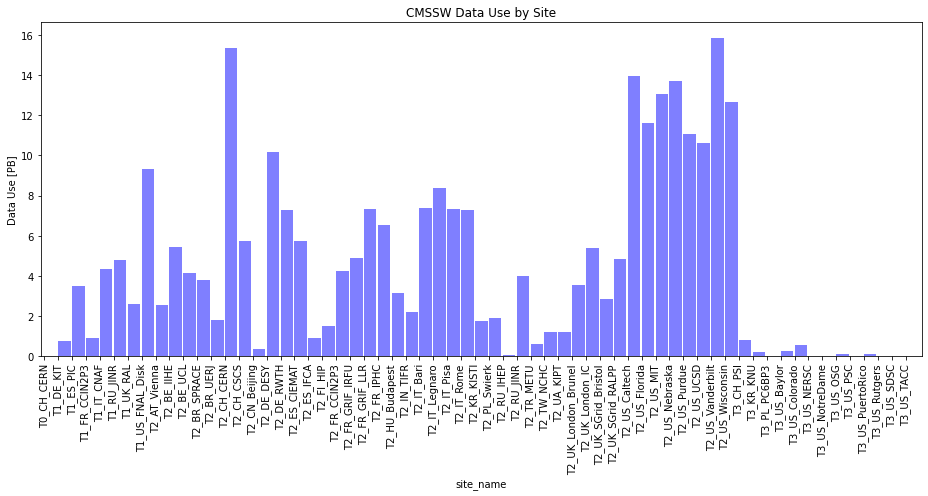

In [12]:
x = np.arange(len(cmssw_set))

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(13)
(cmssw_set/1e15).plot.bar(align='edge', width=0.9, label='CMSSW', alpha=0.5, color='blue')

ax.set_ylabel('Data Use [PB]')
ax.set_title('CMSSW Data Use by Site')
ax.set_xticks(x)

fig.tight_layout()

fig.savefig("plots/site_cmssw.pdf")

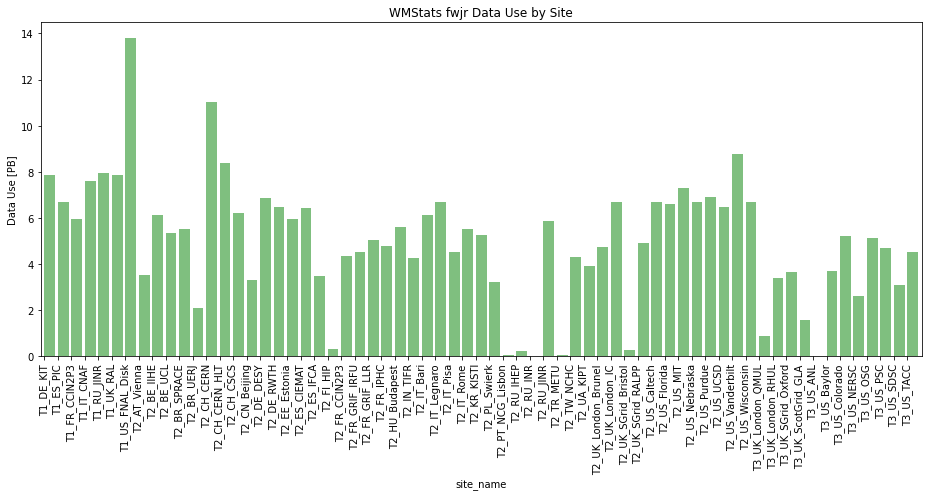

In [13]:
x = np.arange(len(fwjr_set))

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(13)
(fwjr_set/1e15).plot.bar(align='edge', width=0.8, label='WMStats fwjr', alpha=0.5, color='green')

ax.set_ylabel('Data Use [PB]')
ax.set_title('WMStats fwjr Data Use by Site')
ax.set_xticks(x)

fig.tight_layout()

fig.savefig("plots/site_fwjr.pdf")

In [46]:
combined = pd.concat([cmssw_set.rename('cmssw')/1e15, fwjr_set.rename('fwjr')/1e15], axis=1).sort_index()

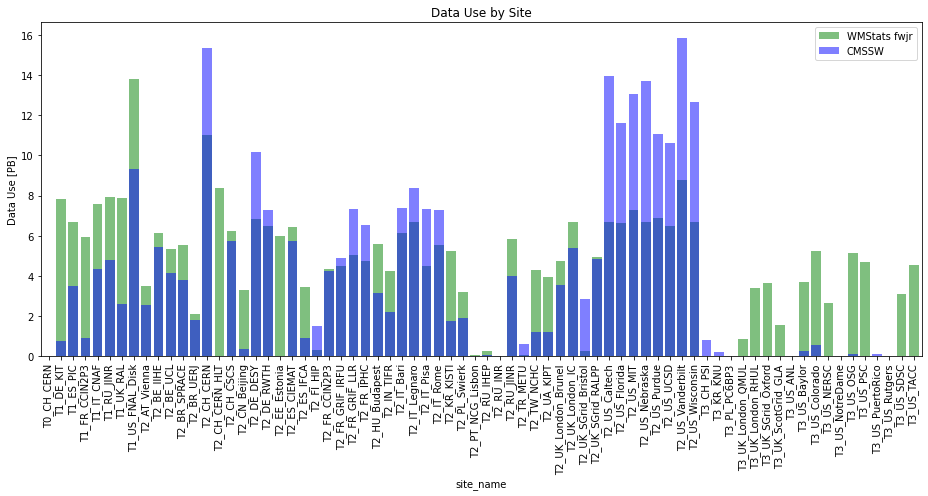

In [50]:
x = np.arange(len(combined.fwjr))

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(13)
combined.fwjr.plot.bar(align='center', width=0.8, label='WMStats fwjr', alpha=0.5, color='green')
combined.cmssw.plot.bar(align='center', width=0.8, label='CMSSW', alpha=0.5, color='blue')

ax.set_ylabel('Data Use [PB]')
ax.set_title('Data Use by Site')
ax.set_xticks(x)
ax.legend()

fig.tight_layout()
fig.savefig("plots/site_fwjr_cmssw.pdf")

In [54]:
cmssw_set/1e15

site_name
T0_CH_CERN          0.000194
T1_DE_KIT           0.786035
T1_ES_PIC           3.518252
T1_FR_CCIN2P3       0.900187
T1_IT_CNAF          4.361240
                      ...   
T3_US_PSC           0.018731
T3_US_PuertoRico    0.143360
T3_US_Rutgers       0.011520
T3_US_SDSC          0.006533
T3_US_TACC          0.020290
Name: working_set_blocks, Length: 63, dtype: float64

In [ ]:
#Usage as a proportion of storage available (static and rucio)
#Give plots for both filtered and unfiltered
#Add filter for is_crab==True

#Look at how often total storage is used per site (90th percentile)
#Same as above but multiply total by 0.4 (typical use for data pop) first 
#Get variance by cite for the above as well 

##https://ncsmith.web.cern.ch/ncsmith/phedex2rucio/rucio_summary.pkl.gz

In [52]:
print('FWJR Total: ',sum(fwjr_set/1e15), ' PB')
print('CMSSW Total: ',sum(cmssw_set/1e15), ' PB')

FWJR Total:  324.68118914454897  PB
CMSSW Total:  282.06651725114597  PB


In [60]:
pd.read_pickle('https://ncsmith.web.cern.ch/ncsmith/phedex2rucio/rucio_summary.pkl.gz')

used                                            \
source                    expired      obsolete        reaper         rucio   
rse                                                                           
T1_DE_KIT_Disk       2.105968e+15  0.000000e+00  6.041723e+15  6.041723e+15   
T1_ES_PIC_Disk       9.397278e+14  0.000000e+00  2.369358e+15  2.369358e+15   
T1_FR_CCIN2P3_Disk   2.557510e+15  0.000000e+00  4.920691e+15  4.920691e+15   
T1_IT_CNAF_Disk      2.730551e+15  0.000000e+00  6.660148e+15  6.660148e+15   
T1_RU_JINR_Disk      3.417765e+15  0.000000e+00  6.850943e+15  6.850943e+15   
T1_UK_RAL_Disk       1.754280e+15  3.496440e+11  4.722224e+15  4.722224e+15   
T1_US_FNAL_Disk      0.000000e+00  0.000000e+00  2.599475e+16  2.599475e+16   
T2_AT_Vienna         2.735024e+14  0.000000e+00  3.559009e+14  3.559009e+14   
T2_BE_IIHE           2.230116e+15  0.000000e+00  3.481677e+15  3.481677e+15   
T2_BE_UCL            6.865061e+14  0.000000e+00  1.566909e+15  1.566909e+15   
T2_BR_SPRACE         1.205952e+15  0.000000e+00  1.797602e+15  1.797602e+15   
T2_BR_UERJ           1.045476e+14  0.000000e+00  2.330770e+14  2.330770e+14   
T2_CH_CERN           0.000000e+00  0.000000e+00  1.288234e+16  1.288234e+16   
T2_CH_CSCS           3.199804e+14  0.000000e+00  1.088778e+15  1.088778e+15   
T2_CN_Beijing        2.066001e+14  0.000000e+00  3.167134e+14  3.167134e+14   
T2_DE_DESY           1.391348e+15  0.000000e+00  5.144150e+15  5.144150e+15   
T2_DE_RWTH           9.527045e+14  0.000000e+00  1.751603e+15  1.751603e+15   
T2_EE_Estonia        5.342384e+14  0.000000e+00  1.008528e+15  1.008528e+15   
T2_ES_CIEMAT         1.158579e+15  0.000000e+00  2.065099e+15  2.065099e+15   
T2_ES_IFCA           3.581502e+14  0.000000e+00  6.249902e+14  6.249902e+14   
T2_FI_HIP            6.643259e+14  0.000000e+00  8.541109e+14  8.541109e+14   
T2_FR_GRIF_IRFU      7.172130e+14  0.000000e+00  1.124023e+15  1.124023e+15   
T2_FR_GRIF_LLR       5.094277e+14  0.000000e+00  1.013594e+15  1.013594e+15   
T2_FR_IPHC           1.052591e+15  2.700000e+08  1.597884e+15  1.597884e+15   
T2_GR_Ioannina       1.010292e+14  5.320195e+09  1.325415e+14  1.325415e+14   
T2_HU_Budapest       5.037868e+14  0.000000e+00  7.742902e+14  7.742902e+14   
T2_IN_TIFR           9.103063e+14  0.000000e+00  1.442191e+15  1.442191e+15   
T2_IT_Bari           5.925089e+14  0.000000e+00  1.293241e+15  1.293241e+15   
T2_IT_Legnaro        1.097679e+15  0.000000e+00  2.401243e+15  2.401243e+15   
T2_IT_Pisa           1.248608e+15  0.000000e+00  1.817199e+15  1.817199e+15   
T2_IT_Rome           3.242507e+14  0.000000e+00  6.009046e+14  6.009046e+14   
T2_KR_KISTI          3.920561e+14  0.000000e+00  7.067333e+14  7.067333e+14   
T2_PK_NCP            9.049867e+13  7.872737e+13  1.820488e+14  1.820488e+14   
T2_PL_Swierk         2.732473e+14  0.000000e+00  6.176337e+14  6.176337e+14   
T2_PT_NCG_Lisbon     7.880773e+13  0.000000e+00  1.745893e+14  1.745893e+14   
T2_RU_IHEP           1.776640e+14  0.000000e+00  2.690358e+14  2.690358e+14   
T2_RU_INR            1.553006e+14  2.334057e+12  2.124842e+14  2.124842e+14   
T2_RU_ITEP           2.012569e+14  5.400000e+08  2.116260e+14  2.116260e+14   
T2_RU_JINR           5.042114e+14  0.000000e+00  9.382451e+14  9.382451e+14   
T2_TR_METU           3.557970e+14  5.070738e+10  4.288031e+14  4.288031e+14   
T2_TW_NCHC           2.417513e+14  0.000000e+00  4.085431e+14  4.085431e+14   
T2_UA_KIPT           5.876655e+14  0.000000e+00  7.609904e+14  7.609904e+14   
T2_UK_London_Brunel  2.666180e+14  5.405301e+12  5.881197e+14  5.881197e+14   
T2_UK_London_IC      1.199764e+14  0.000000e+00  1.743313e+15  1.743313e+15   
T2_UK_SGrid_Bristol  8.415708e+10  8.415708e+10  1.980849e+14  1.980849e+14   
T2_UK_SGrid_RALPP    8.990864e+14  0.000000e+00  1.399022e+15  1.399022e+15   
T2_US_Florida        4.207125e+14  0.000000e+00  2.617437e+15  2.617437e+15   
T2_US_MIT            3.049586e+14  0.000000e+00  4.446455e+15  4.446455e+15   
